# Dependancies

In [64]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
import torch
from torch_geometric.data import Data
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import torch.optim as optim
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import torch.optim as optim
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import KMeans

# Data Loading

In [65]:
# Load the dataset
file_path = 'yelp_review_cleaned_dataset.csv'
df = pd.read_csv(file_path)

# Limit the size of the dataset
df = df.sample(n=5000, random_state=42)

np.random.seed(42)
df['is_fake'] = np.random.choice([0, 1], size=len(df), p=[0.9, 0.1])

# Display basic information about the dataset
df.info(), df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 5000 entries, 6252 to 2764
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   review_id     5000 non-null   object
 1   user_id       5000 non-null   object
 2   business_id   5000 non-null   object
 3   stars         5000 non-null   int64 
 4   useful        5000 non-null   int64 
 5   funny         5000 non-null   int64 
 6   cool          5000 non-null   int64 
 7   text          5000 non-null   object
 8   date          5000 non-null   object
 9   cleaned_text  5000 non-null   object
 10  is_fake       5000 non-null   int64 
dtypes: int64(5), object(6)
memory usage: 468.8+ KB


(None,
                    review_id                 user_id             business_id  \
 6252  DXZtkvp3zgHfwOyQ8He0jQ  gatM0_LzUSqNEmlQcBPiBQ  bXjnfT69E8DJinX-ifOofA   
 4684  BRmDLZSJH_YLsbpJ9_VC6Q  dQIgI_eyox_Q4qK0T6iKmA  jLDwSeoQ_kDQwhnUJQO2yw   
 1731  34ZT45dZD_JXbU5rvuyJgg  0xapSfoASxW3pozvAK_DIQ  4nSnvxK-4lKwZvXDGYK5Uw   
 4742  nHwzviHqA97g7341VT2aWw  _GW_i-3PFWZNMjLc_YMXpw  0hIXH9jMdHov1VrLC8ujUg   
 4521  DAe6ffProBgui30TGuFF4g  tGlcQt6syMPeIGKFUXOlmg  1JtpcHELRrSDoWS80WtzuQ   
 
       stars  useful  funny  cool  \
 6252      1       0      0     0   
 4684      3       1      0     0   
 1731      4       3      0     1   
 4742      5       0      0     0   
 4521      5       2      0     0   
 
                                                    text                 date  \
 6252  I can not believe on how unprofessional we wer...  2018-06-19 20:32:28   
 4684  Before one thing got under my skin, I would sa...  2016-07-05 00:10:57   
 1731  This location has been newly re

# Data Statistics

In [68]:
# Preprocess the cleaned text data
vectorizer = TfidfVectorizer(max_features=300)
text_embeddings = vectorizer.fit_transform(df['cleaned_text']).toarray()

# Encode user_id and business_id
user_encoder = LabelEncoder()
business_encoder = LabelEncoder()
df['user_id_encoded'] = user_encoder.fit_transform(df['user_id'])
df['business_id_encoded'] = business_encoder.fit_transform(df['business_id'])

# Number of reviews, users, and businesses
num_reviews = df.shape[0]
num_users = df['user_id_encoded'].nunique()
num_businesses = df['business_id_encoded'].nunique()

# Create a feature matrix for reviews
review_features = torch.tensor(text_embeddings, dtype=torch.float)

# Create placeholder features for users and businesses
user_features = torch.zeros((num_users, review_features.shape[1]))
business_features = torch.zeros((num_businesses, review_features.shape[1]))

# Concatenate all features to create the final feature matrix
features = torch.cat([review_features, user_features, business_features], dim=0)

# Display the encoded IDs and features
print(df[['user_id_encoded', 'business_id_encoded']].head())
print(features.shape)
print(f'Number of reviews: {num_reviews}')
print(f'Number of users: {num_users}')
print(f'Number of businesses: {num_businesses}')


      user_id_encoded  business_id_encoded
3429             3349                  529
7774              944                 2497
8179             1443                 1042
705              4352                  980
9134             4556                   48
torch.Size([12470, 300])
Number of reviews: 5000
Number of users: 4894
Number of businesses: 2576


In [69]:
# Correctly calculate the total number of nodes
total_nodes = num_reviews + num_users + num_businesses

# Create edge index (connections between nodes)
user_edges = []
business_edges = []

# Create user edges
for idx, row in df.iterrows():
    user_edge = num_reviews + row['user_id_encoded']
    if user_edge < total_nodes:
        user_edges.append([idx, user_edge])
    else:
        raise ValueError(f"User edge index out of bounds: {user_edge}")

# Create business edges
for idx, row in df.iterrows():
    business_edge = num_reviews + num_users + row['business_id_encoded']
    if business_edge < total_nodes:
        business_edges.append([idx, business_edge])
    else:
        raise ValueError(f"Business edge index out of bounds: {business_edge}")

# Combine edges
edges = torch.tensor(user_edges + business_edges, dtype=torch.long).t().contiguous()

# Ensure the edges do not go out of bounds
if edges.max().item() >= total_nodes:
    raise ValueError(f"Edge index out of bounds: {edges.max().item()} >= {total_nodes}")

# Create PyTorch Geometric data object
data = Data(x=features, edge_index=edges)

print(data)


Data(x=[12470, 300], edge_index=[2, 10000])


# GNN Model Training

In [66]:

# Limit the dataset size for quick experimentation
df = df.sample(n=5000, random_state=42)

# Vectorize the cleaned text
vectorizer = TfidfVectorizer(max_features=300)
text_embeddings = vectorizer.fit_transform(df['cleaned_text']).toarray()

# Encode user_id and business_id
user_encoder = LabelEncoder()
business_encoder = LabelEncoder()
df['user_id_encoded'] = user_encoder.fit_transform(df['user_id'])
df['business_id_encoded'] = business_encoder.fit_transform(df['business_id'])

# Create feature matrices for reviews, users, and businesses
review_features = torch.tensor(text_embeddings, dtype=torch.float)
num_users = df['user_id_encoded'].nunique()
num_businesses = df['business_id_encoded'].nunique()

user_features = torch.zeros((num_users, review_features.shape[1]))
business_features = torch.zeros((num_businesses, review_features.shape[1]))

# Concatenate all features to create the final feature matrix
features = torch.cat([review_features, user_features, business_features], dim=0)


In [67]:


# Create edge indices for the graph
review_indices = torch.arange(len(df))
user_indices = torch.tensor(df['user_id_encoded'].values + len(df))
business_indices = torch.tensor(df['business_id_encoded'].values + len(df) + num_users)

# Create edges between reviews and users, and reviews and businesses
edges = torch.stack([torch.cat([review_indices, review_indices]), torch.cat([user_indices, business_indices])], dim=0)

# Create PyTorch Geometric data object
data = Data(x=features, edge_index=edges)

# Define the GCN model
class GCN(torch.nn.Module):
    def __init__(self, num_features):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, 128)
        self.conv2 = GCNConv(128, 64)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

# Initialize model, optimizer, and loss function
model = GCN(features.shape[1])
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

# Train the GCN model
model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out[:len(df)], torch.tensor(df['stars'].values - 1))
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

# Extract embeddings
embeddings = model(data).detach().numpy()





Epoch 0, Loss: 4.14351224899292
Epoch 10, Loss: 1.4069112539291382
Epoch 20, Loss: 1.245862603187561
Epoch 30, Loss: 1.0704710483551025
Epoch 40, Loss: 0.9683461785316467
Epoch 50, Loss: 0.9087242484092712
Epoch 60, Loss: 0.8675592541694641
Epoch 70, Loss: 0.8374133706092834
Epoch 80, Loss: 0.8118687868118286
Epoch 90, Loss: 0.7867642641067505
Epoch 100, Loss: 0.7604496479034424
Epoch 110, Loss: 0.732573390007019
Epoch 120, Loss: 0.7038466930389404
Epoch 130, Loss: 0.6739049553871155
Epoch 140, Loss: 0.6434390544891357
Epoch 150, Loss: 0.6123692393302917
Epoch 160, Loss: 0.5804085731506348
Epoch 170, Loss: 0.5475758910179138
Epoch 180, Loss: 0.514767587184906
Epoch 190, Loss: 0.4829910099506378


# K-Means Unsupervised Learning

In [70]:

# Apply K-Means clustering
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans_labels = kmeans.fit_predict(embeddings[:len(df)])

# Evaluate clustering
sil_score_kmeans = silhouette_score(embeddings[:len(df)], kmeans_labels)
calinski_harabasz_kmeans = calinski_harabasz_score(embeddings[:len(df)], kmeans_labels)
davies_bouldin_kmeans = davies_bouldin_score(embeddings[:len(df)], kmeans_labels)

print(f'K-Means Silhouette Score: {sil_score_kmeans}')
print(f'K-Means Calinski-Harabasz Index: {calinski_harabasz_kmeans}')
print(f'K-Means Davies-Bouldin Index: {davies_bouldin_kmeans}')
# Count the number of fake reviews identified
num_fake_reviews = df['is_fake'].sum()
print(f'Number of fake reviews: {num_fake_reviews}')


K-Means Silhouette Score: 0.45557069778442383
K-Means Calinski-Harabasz Index: 6753.574505613081
K-Means Davies-Bouldin Index: 0.7819971223474159
Number of fake reviews: 479


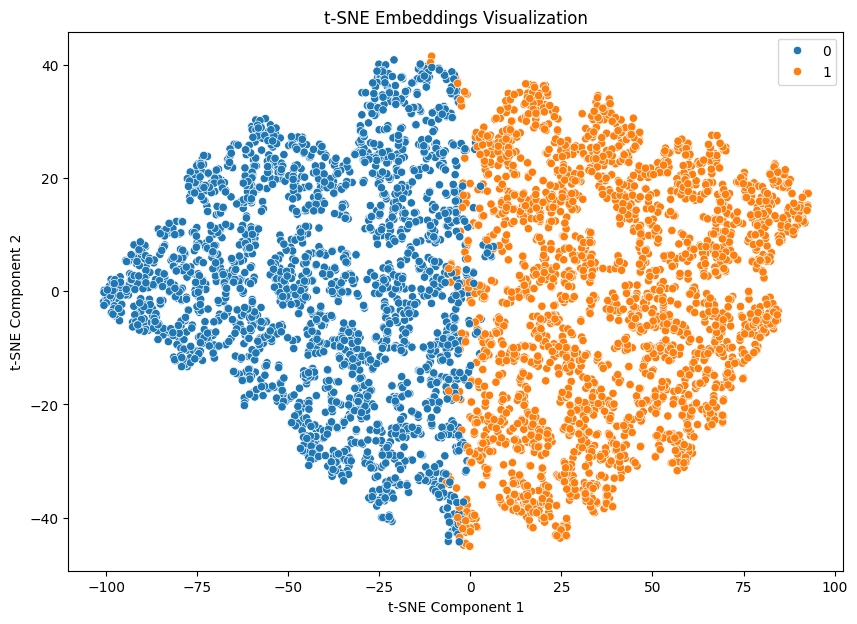

In [71]:

# Reduce dimensions for visualization
tsne = TSNE(n_components=2, random_state=42)
reduced_embeddings = tsne.fit_transform(embeddings[:len(df)])

# Visualize t-SNE
plt.figure(figsize=(10, 7))
sns.scatterplot(x=reduced_embeddings[:, 0], y=reduced_embeddings[:, 1], hue=kmeans_labels)
plt.title('t-SNE Embeddings Visualization')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()
